In last notebook agents chose to be influenced or not. But they always remove all edges at the start of each step. We need a criteria for chosing which links to remove and that would be if edge weight goes below a threshold. So, before continuing weith aour fish model, we need to implement the weighted network in order to give agents a criteria for choosing which neighbors to keep, and which to remove.
Objectives for this notebook are:
* Init a random trust matrix, that can be the init from a graph like erdos-renyi. ATM we're not updating weights of this matrix.
* Give the agent the ability to choose which "friends" to remove based on edge weight threshold

In [1]:
%run _config.ipynb

In [2]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    alfa = model.Price * 0.01 # coefficient for price updating
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'buy':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'sell':
            sso += agent_orders[i]
    
    delta = alfa * (sbo - sso)
    
    model.Last_Price = model.Price
    model.Price = model.Price + delta
    
    return model.Price

In [3]:
def get_graphlabels(ordered_dict):
    inv_dict = dict(zip(ordered_dict.values(), ordered_dict.keys()))
    return inv_dict

In [4]:
def plot_graph(schedule):
    G = schedule.net
    pos = nx.spring_layout(G, k = 10)
    labels = get_graphlabels(schedule._agents)

    plt.figure(figsize=(14, 8))
    s = nx.draw_networkx_nodes(
        G,
        pos,
        node_size = 200,
        node_color = list(dict(nx.degree(G)).values()),
        alpha = 1,
        cmap = plt.cm.BuGn
    )
    
    edge_labels = {e: round(G.edges[e]['weight'], 2) for e in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 6)
    
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels, font_size=6, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

    #show the colorbar on the right side
    cbar = plt.colorbar(s)
    cbar.ax.set_ylabel('Degree', size=12)

    plt.axis('off')
    plt.show();

In [5]:
def sample_from_dict(dic, n):
    keys = random.sample(list(dic), n)
    return {k: dic[k] for k in keys}

In [6]:
def get_neighbors(dict_agents, agent_id):
    dict_agents.pop(agent_id, None) # always exclude himself from the list before taking the sample
    return sample_from_dict(dict_agents, 1) # take a sample of 1 agent

In [7]:
def add_friends(dict_neighbors, self_node):
    node_neighbors = dict_neighbors.values() # e.g. [<__main__.Agent object at 0x7f64f5ca7910>, <__main__.Agent object at 0x7f64f3ca8110>]
    
    tuple_links = list()
    for neighbour_node in node_neighbors:
        tuple_links.append((self_node, neighbour_node, random.uniform(0.40, 0.60)))
    
    return tuple_links

In [8]:
def remember_linked_neighbors(G, node_id):
    return G.edges(node_id)

In [9]:
def remove_friends(G, self_node, trust_thr):
    my_edges = list(G.edges(self_node, data = True))
    
    tuple_links_to_remove = list()
    for edge in my_edges:
        if edge[2]['weight'] < trust_thr: # If weight of friend is less than my desired threshold i remove him from friends list
            tuple_links_to_remove.append((self_node, edge[1]))
    
    return tuple_links_to_remove

In [10]:
from collections import Counter # agent is now able to count from 1 to 10

def check_socials(friends_list):
    friends_positions = [ friend.position for friend in friends_list ]
    dic = Counter(friends_positions)
    
    max_key = max(dic, key = dic.get)
    return max_key # we return influence when using also the trust matrix

In [11]:
class Agent_Rnd_Trader(mesa.Agent):
    def __init__(self, unique_id, model, wealth, position, order):
        super().__init__(unique_id, model)
        
        self.type = 'random'
        self.unique_id = unique_id
        self.node_id = None
        
        # DOF Agent
        self.wealth = round(wealth * ( 1. + 0.1 * random.uniform(-1, 1) ), 2) # cash
        self.position = position # initial position, buy or sell
        self.order = order # quantities ordered
        self.trust_thr = 0.50
        
        self.neighbors = dict()
        self.influence = list()
        #printing init stats
        #print(f'{unique_id}: \t $ {round(self.wealth, 2)}')
        
    def _see(self):
        self.Price = model.Price
        self.node_id = self.model.schedule._agents[self.unique_id]
        
        self.neighbors = get_neighbors(self.model.schedule._agents.copy(), self.unique_id) # for linking
        
    def _next(self):
        # update friends_list periodically (which means not really periodically but who knows what goes in an agent's head lol)
        if random.uniform(0, 1) < 0.20:
            self.model.schedule.net.remove_edges_from(remove_friends(self.model.schedule.net.copy(), self.node_id, self.trust_thr)) # Rimuovi Amicizia
            self.model.schedule.net.add_weighted_edges_from(add_friends(self.neighbors, self.node_id)) # Aggiungi Amico
        
        # Let the agent know what others are doing, so he can be influeced by it or not
        #print(f'Me, agent {self.unique_id}, see that these are my friends: {self.neighbors.values()} with position {[el.position for el in list(self.neighbors.values())]}')
        
        self.influence = check_socials(list(self.neighbors.values())) # Check his friends activity, there may be friends who still didn't open any position, and some who did
        
    def _action(self):
        if random.uniform(0, 1) < 0.5: # Agent chooses to be influeced
            self.position = self.influence
            self.order = 1
        else:
            self.rnd_trade()
            
    # Random Trader Functions
    def rnd_trade(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'buy'
            self.order = 1 #randomize also this later
        else:
            self.position = 'sell'
            self.order = 1
            
        self.wealth = self.wealth - self.order * self.Price
        
    # Step Function for random trader agent
    def step(self):
        self.wealth += 1
        
        self._see()
        self._next()
        self._action()

In [12]:
# INIT WITH ERDOS RENYI
def get_ER_mapped_edges(N_agents, prob, labels):
    ER = nx.erdos_renyi_graph(N_agents, prob)
    list_edges = list(ER.edges())
    
    mapped_edges = list()
    for edge in list_edges:
        node1 = list(labels.keys())[list(labels.values()).index(f'rnd_trader_{edge[0]}')]
        node2 = list(labels.keys())[list(labels.values()).index(f'rnd_trader_{edge[1]}')]
        mapped_edges.append((node1, node2))
        
    return mapped_edges

In [18]:
class Market_Model(mesa.Model):
    def __init__(self, N_agents, Price):
        
        # Environment Settings
        self.schedule = mlm.MultiLevel_Mesa(self, group_to_net = True)
        
        # Model Parameters
        self.Price = Price; self.Last_Price = self.Price
        self.N_agents = N_agents
        
        # Create Random Traders
        N_rnd_traders = N_agents
        wealth = 400; position = 'null'; order = 0
        
        for a in range(N_rnd_traders):
            unique_id = f'rnd_trader_{a}'
            ag = Agent_Rnd_Trader(
                unique_id,
                self,
                wealth, position, order
            )
            self.schedule.add(ag)
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters = {'Price': change_Prices},
            agent_reporters = {
                'wealth': 'wealth',
                'position': 'position',
                'order': 'order'
            }
        )
        
        # Network initialization with Erdos Renyi
        self.schedule.net.add_edges_from(
            get_ER_mapped_edges(
                self.N_agents,
                0.05,
                get_graphlabels(self.schedule._agents)
            )
        )
        print('Init Network')
        #plot_graph(self.schedule)
        
        # Init also weights to random ones
        for (u, v) in self.schedule.net.edges():
            self.schedule.net.edges[u, v]['weight'] = random.uniform(0, 1)
        plot_graph(self.schedule)
        
    def step(self): 
        for i in range(self.N_agents): # Before the day starts reset all positions to null
            vars(self.schedule.agents[i])['position'] = 'null'
                
        #step the groups and agents
        self.schedule.step()
        
        #plot_graph(self.schedule)
        
        # plot weights
        #for (u, v) in self.schedule.net.edges():
        #    print(self.schedule.net.edges[u, v])
            
        # Collect data at that timestep
        self.datacollector.collect(self)

Init Network


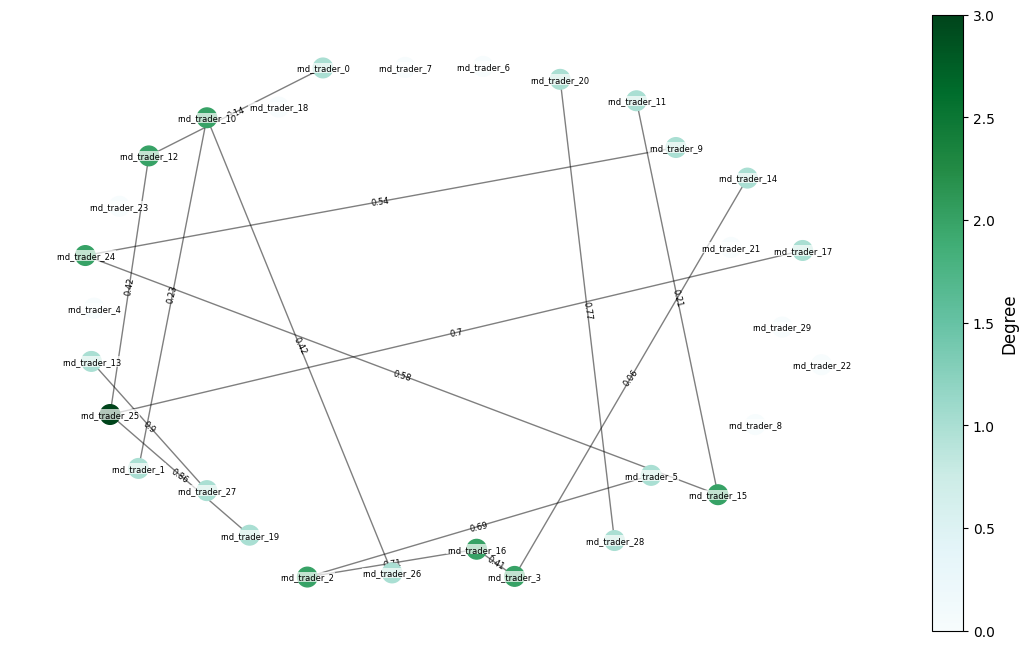

In [19]:
random.seed(42)

for run in range(1):
    model = Market_Model(N_agents = 30, Price = 10)
    
    N_steps = 500
    for step in range(N_steps):
        model.step()

In [20]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

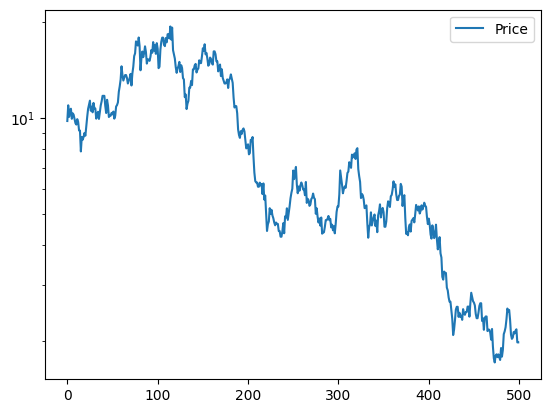

In [21]:
model_vars.plot();
plt.yscale('log');

In [22]:
model_vars.to_csv('model_vars.csv')

We checked:
* Random activation is godlike, each step agents activate in a different order everytime.
* Each agent can see its neighbors positions and be influeced, atm no trust matrix but all weights are 1.
* At the beginning of each model step all agents positions are set to 'null'.
* Reduced computational complexity by returning influenced only as a position (geniuz) and solved the bug of market trend depending on algorythm position of if else.
* Fishes choose periodically to update their friends list and at the moment weights are NOT updated because of some feedback.